In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os
import re
from transformers import TrainerCallback

os.environ["WANDB_DISABLED"] = "true"

#!pip install datasets

def clean_text_list(text_list):
    # Handle None values and convert all to strings
    cleaned_list = [str(text) if text is not None else "" for text in text_list]

    # Helper function to remove wallet addresses (assuming this is what remove_wallets does)
    def remove_wallets(text):
        # This is a basic implementation - modify if your original remove_wallets was different
        # Common crypto wallet patterns (like Bitcoin/Ethereum addresses)
        wallet_pattern = r'0x[a-fA-F0-9]{40}|[13][a-km-zA-HJ-NP-Z1-9]{25,34}'
        return re.sub(wallet_pattern, '', text)

    # Apply cleaning operations
    def clean_text(text):
        # Remove Asian characters
        text = re.sub(r'[\u4e00-\u9fff]+', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove mentions, hashtags, stock symbols, and forward slashes with content
        #text = re.sub(r'[@][A-Za-z0-9_]+|#[A-Za-z0-9_]+|$[A-Za-z0-9_ ]+|/[A-Za-z0-9_ ]+', '', text)
        # Remove RT prefix
        text = re.sub(r'RT : ', '', text)
        # Replace & with 'and'
        text = re.sub(r'&', 'and', text)
        # Handle special characters and quotes
        text = re.sub(r'â€™', '\'', text)
        text = re.sub(r'["&;]', '', text)
        text = re.sub(r'', '', text)  # Zero-width space
        # Remove .X or .x
        text = re.sub(r'\.[Xx]', '', text)
        # Normalize multiple dots to ellipsis
        text = re.sub(r'\.\.+', '...', text)
        # Remove standalone @ and pipe symbols
        text = re.sub(r'@|\|', '', text)
        # Normalize spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Convert to lowercase
        text = text.lower()
        # Remove wallet addresses
        text = remove_wallets(text)
        return text

    # Apply cleaning to all texts
    cleaned_list = [clean_text(text) for text in cleaned_list]

    # # Remove duplicates and filter by minimum word count (4 words)
    # seen = set()
    # result = []
    # for text in cleaned_list:
    #     if text and text not in seen and len(text.split()) >= 4:
    #         seen.add(text)
    #         result.append(text)

    return cleaned_list

In [ ]:
data = load_dataset("StephanAkkerman/financial-tweets-crypto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_dataset_ori = data['train']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Clean the text data
texts = clean_text_list(train_dataset_ori['description'])

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(texts)

# Apply K-Means clustering
num_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Store results
if "cluster" in train_dataset_ori.column_names:
    train_dataset_ori = train_dataset_ori.remove_columns("cluster")

train_dataset_ori = train_dataset_ori.add_column("cluster", clusters)

# Save the trained model
import joblib
joblib.dump(kmeans, "models/kmeans_model.pkl")
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

print("K-Means clustering completed and saved to models.")


K-Means clustering completed and saved to models.


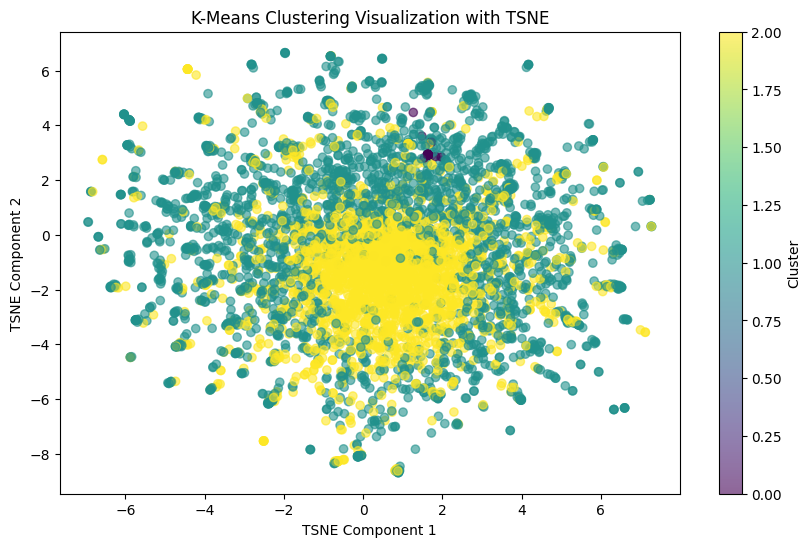

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have your vectorizer and transformed features
# If you named it differently, change 'tfidf_features'
subset_size = 5000  # Adjust as needed
features_tfidf = vectorizer.fit_transform(texts)
sample_indices = np.random.choice(len(features_tfidf.toarray()), subset_size, replace=False)
sampled_features = features_tfidf.toarray()[sample_indices]
sampled_clusters = np.array(clusters)[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_features = tsne.fit_transform(sampled_features)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=sampled_clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title("K-Means Clustering Visualization with TSNE")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()